In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import math

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
def show_image(img):
    imPlot1 = img[:,:,::-1]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.rcParams["figure.figsize"] = (25, 9)
    plt.imshow(imPlot1)
    
def show_gimage(img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
    
def plotTwo(img1, img2):
    imPlot1 = img1[:,:,::-1]
    imPlot2 = img2[:,:,::-1]

    width, height = imPlot1.shape[:2]

    fig = plt.figure(figsize=(width/10, height/10))

    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    plt.imshow(imPlot1)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(imPlot2)
    
    plt.show()

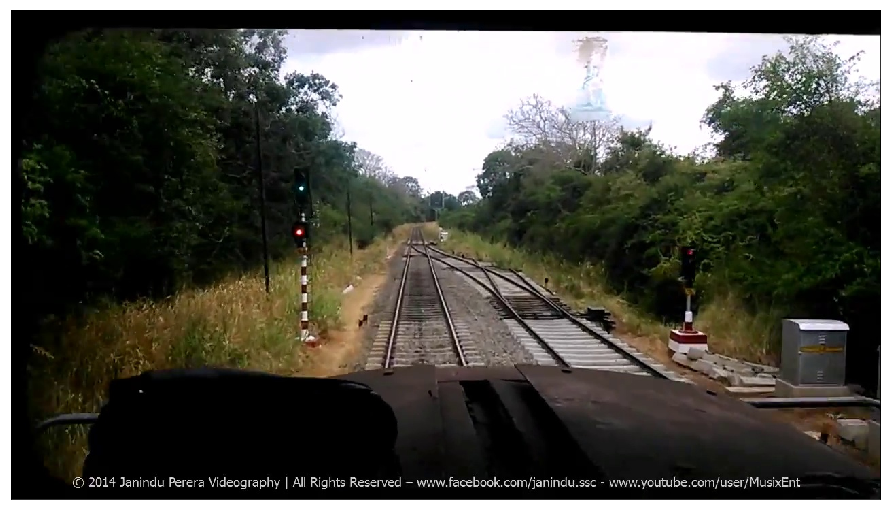

In [23]:
img = cv.imread('../images/video-x/frame23.jpg')
show_image(img)

(720, 1280, 3)


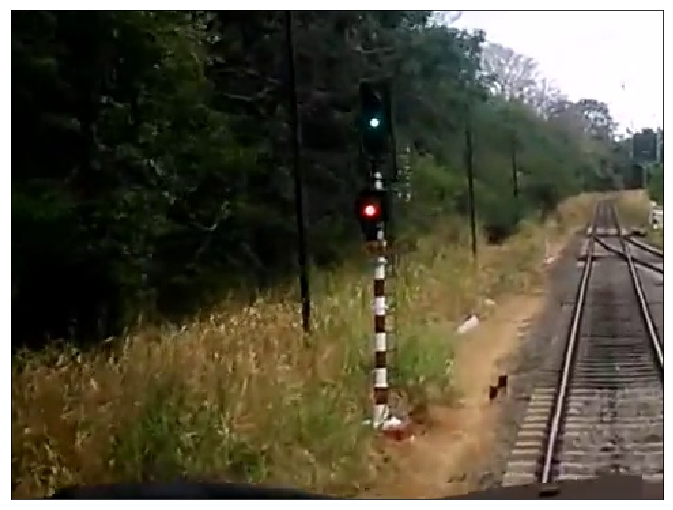

In [24]:
# Take only left
h,w,c = img.shape
print(img.shape)
cropped_img = img[math.floor(h/4):math.floor(h*3/4)]
cropped_img = cropped_img[:,math.floor(w/8):math.floor(w/2)]
cr_h,cr_w,_ = cropped_img.shape

show_image(cropped_img)

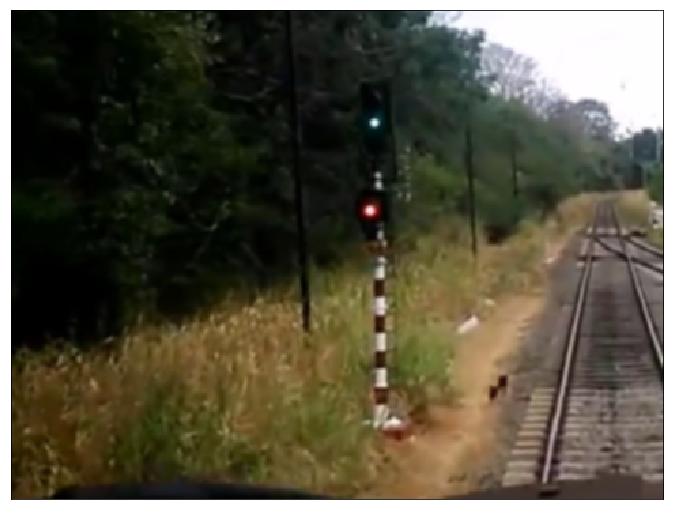

In [25]:
# Apply gaussian Blur
blured = cv.GaussianBlur(cropped_img, (5,5),0 )
show_image(blured)

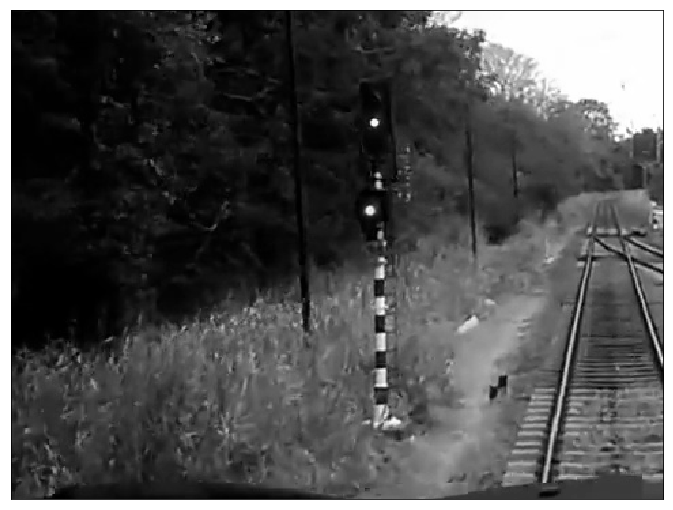

In [26]:
gray = cv.cvtColor(cropped_img, cv.COLOR_BGR2GRAY)
show_gimage(gray)


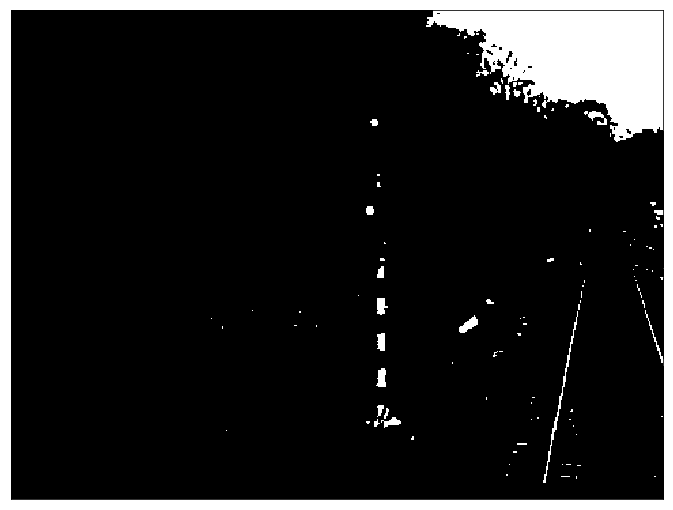

In [27]:
ret, gb = cv.threshold(gray,170,255,cv.THRESH_BINARY)

#gb = cv.bitwise_not(gb)
show_gimage(gb)

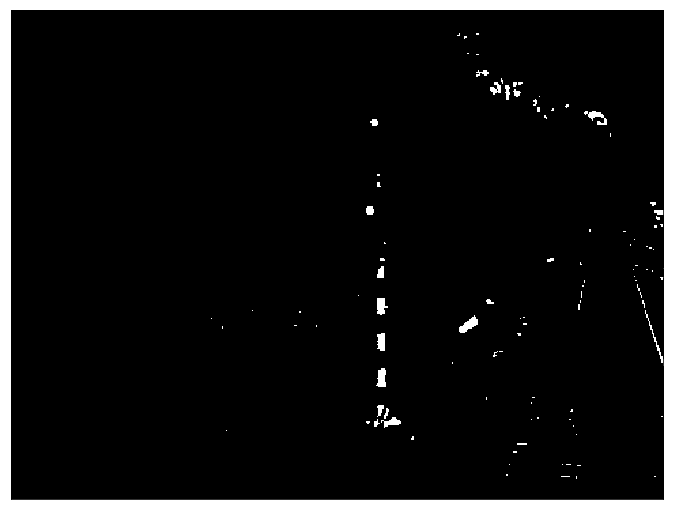

In [28]:
#find all your connected components (white blobs in your image)
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(gb, connectivity=8)
#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 150  

#your answer image
img2 = np.zeros((gb.shape))
#for every component in the image, you remove it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] <= min_size:
        img2[output == i + 1] = 255
        
new_image = img2.astype(np.uint8)

show_gimage(img2)

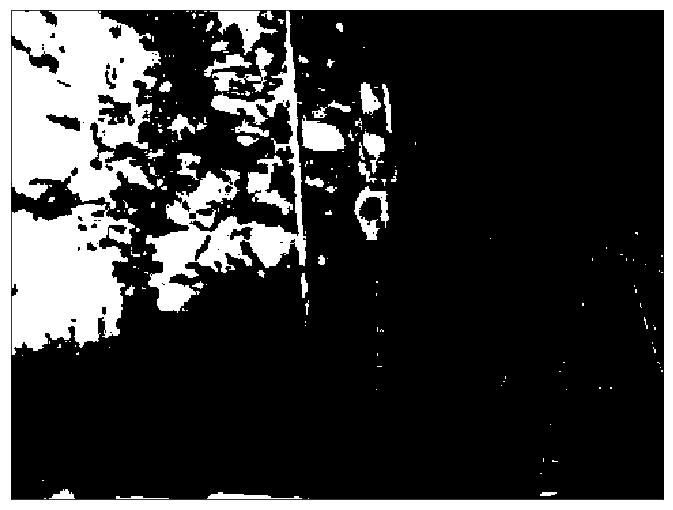

In [29]:
ret, black_shape = cv.threshold(gray,10,255,cv.THRESH_BINARY_INV)

#gb = cv.bitwise_not(gb)
show_gimage(black_shape)

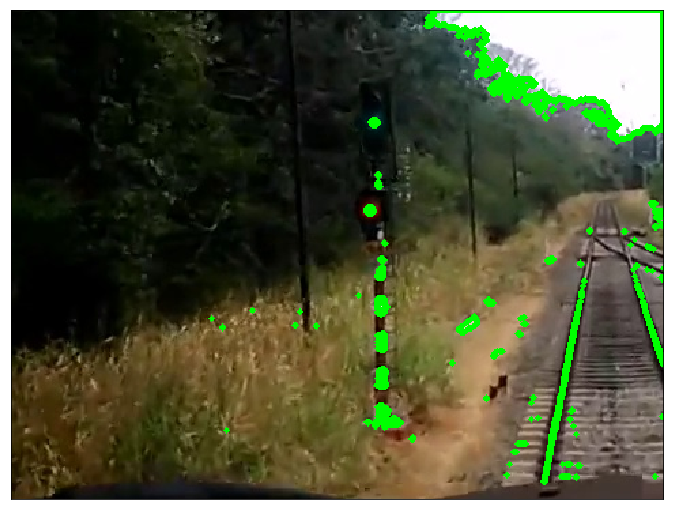

In [30]:
def draw(img, org):
    sky = org.copy()
    contours,hierachy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    rects = []   
    if len(contours) != 0:
        cv.drawContours(sky, contours, -1, (0,255,0), 3)
    show_image(sky) 
    
draw(gb, cropped_img)

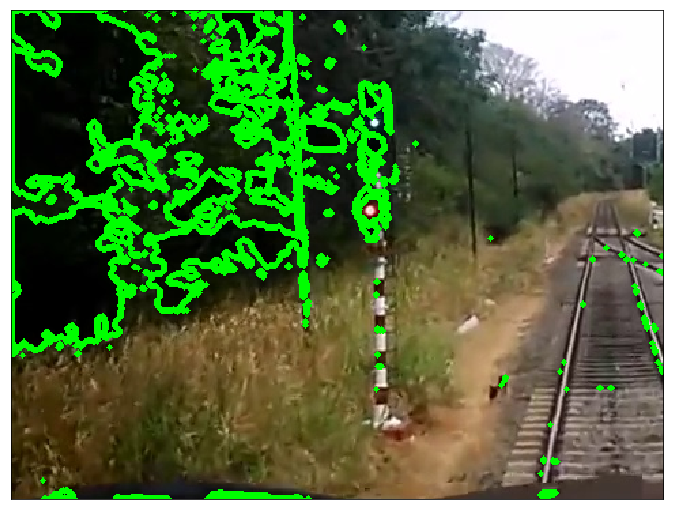

In [31]:
draw(black_shape, cropped_img)

180.0
120.0
1


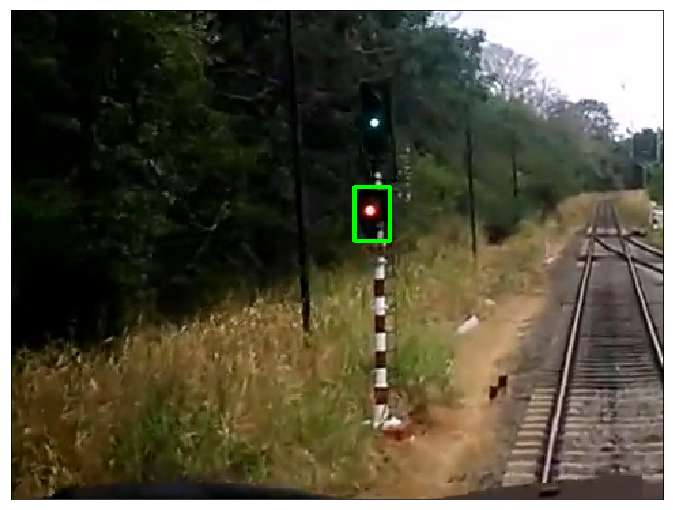

In [32]:
contours_light,_ = cv.findContours(gb, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
contours_black,_ = cv.findContours(black_shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
thresh_height = cr_h/2
thresh_width = cr_w/4
print(thresh_height)
print(thresh_width)
trafic_lights = []
for _, c in enumerate(contours_black):
    area_black = cv.contourArea(c)    
    if area_black > 0:
        #print(area_black)
        x,y,w,h = cv.boundingRect(c)      
        if w < thresh_width and h < thresh_height:
            for _, cl in enumerate(contours_light):
                area_light = cv.contourArea(cl)             
                if area_light > 0 and area_black > area_light:                
                    xl,yl,wl,hl = cv.boundingRect(cl)
                    if (x < xl and x+w > xl+ wl and y < yl and y+h > yl+hl):
                        trafic_lights.append(c)
                    
output = cropped_img.copy()
print(len(trafic_lights))
for c in trafic_lights:    
    x,y,w,h = cv.boundingRect(c)
    cv.rectangle(output, (x,y), (x+w, y+h), (0,255,0),2)
show_image(output)

In [ ]:
show_gimage(gb)

In [ ]:
img_s = black_shape + gb
show_gimage(img_s)

In [ ]:
img_no_s = img_s - erosion1
show_gimage(img_no_s)

In [ ]:
kernel = np.ones((2,2),np.uint8)
dilated_no_s = cv.dilate(img_no_s, kernel,iterations = 2)
show_gimage(dilated_no_s)


In [ ]:
kernel = np.ones((4,4),np.uint8)
erosion = cv.erode(gb,kernel,iterations = 2)
show_gimage(erosion)

In [ ]:
kernel = np.ones((5,5),np.uint8)
dilated = cv.dilate(erosion, kernel,iterations = 3)
show_gimage(dilated)


In [ ]:
mask = cv.bitwise_not(dilated)
lt = cv.bitwise_and(gb, gb, mask=mask)
show_gimage(lt)

In [ ]:
kernel = cv.getStructuringElement(shape=cv.MORPH_RECT, ksize=(2,2))
smooth = cv.morphologyEx(gb, cv.MORPH_DILATE, kernel,iterations = 4)
show_gimage(smooth)

In [ ]:
def draw_large_contour(img, org):
    output = org.copy()
    contours,hierachy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    rects = []   
    if len(contours) != 0:
        #cv.drawContours(output, contours, -1, (0,255,0), 3)       
        #c = max(contours, key = cv.contourArea)
        areaArray = []
        for i, c in enumerate(contours):
            area = cv2.contourArea(c)
            areaArray.append(area)

        #first sort the array by area
        sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)
        
        first = sorteddata[0][1]
        
        #find the nth largest contour [n-1][1], in this case 2
        second = sorteddata[2][1]
        
        x,y,w,h = cv.boundingRect(first)
        cv.rectangle(output, (x,y), (x+w, y+h), (0,255,0),2)
        #img[math.floor(h/4):math.floor(h*3/4)]
        rects.append(org[y:y+h,x:x+w])
        
        x2,y2,w2,h2 = cv.boundingRect(second)
        cv.rectangle(output, (x2,y2), (x2+w2, y2+h2), (0,255,0),2)
        rects.append(org[y2:y2+h2,x2:x2+w2])
        
    return (output, rects)

In [ ]:
ct,rects = draw_large_contour(black_shape, cropped_img)
show_image(ct)

In [ ]:
show_image(rects[0])

In [ ]:
show_image(rects[1])